# This scripts contains the process of generating semantic contexts

In [1]:
import pandas as pd 
import numpy as np
import re
import pickle
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import os
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD
from scipy.stats import pearsonr
import wordcloud as wc
import matplotlib.pyplot as plt
import matplotlib.image as img
import seaborn as sns
import nltk
from nltk.corpus import stopwords
from sklearn.decomposition import NMF

In [13]:
tmp_dir = "/Users/enningyang/Documents/forrest_project/tmp_data"
component_names_240_7 = {0: "global signal", 1: "lieutenant dan", 
                       2: "vietnam war", 3: "D.C.", 
                       4:"jenny and mom", 5:"childhood", 6:"vietnam war2"}
component_names_240_5 = {0:"global signal", 1:"lieutenant dan", 2:"vietnam war", 3:"D.C.", 4:"jenny and mom"}
c_names_dict = {5:component_names_240_5, 7:component_names_240_7,200:{i:i for i in range(200)}}
np.save(f"{tmp_dir}c_names_dict.npy",c_names_dict)
save_fig = 0

In [5]:
w = wc.WordCloud(background_color = "white")
n_components = 200
nmf = 1
if nmf:
    tail = "_nmf"
else:
    tail = "_pca"
window_length = 240
component_names_240_7 = {0: "global signal", 1: "lieutenant dan", 
                       2: "vietnam war", 3: "D.C.", 
                       4:"jenny and mom", 5:"childhood", 6:"vietnam war2"}
component_names_240_5 = {0:"global signal", 1:"lieutenant dan", 2:"vietnam war", 3:"D.C.", 4:"jenny and mom"}

opt = "sub"

if opt == "sub":
    df = pd.read_csv(f'{tmp_dir}/english_dialog.csv')
    df = df.dropna().reset_index()
    stopset = stopwords.words('english')
elif opt == "des":
    df = pd.read_csv(f'{tmp_dir}/german_audio_description.csv')
    df = df.dropna().reset_index()
    stopset = stopwords.words('german')
else: 
    df1 = pd.read_csv(f'{tmp_dir}/english_dialog.csv')
    df1 = df1.dropna().reset_index()
    df2 = pd.read_csv(f'{tmp_dir}/german_audio_description.csv')
    df2 = df2.dropna().reset_index()
    stopset1 = stopwords.words('english')
    stopset2 = stopwords.words('german')
    stopset = stopset1+stopset2
    df = df1.append(df2, ignore_index=True)



In [7]:
# stopset = stopset.append('gesang')
def vectorizer(df,verbose=False):
    corpus = df.text.to_numpy()
    cv = CountVectorizer(stop_words=stopset,ngram_range=(1, 1))
    cv.fit(corpus)
    X = cv.transform(corpus)
    text = X.toarray()
    if verbose:
        return text, cv
    else:
        return text

def sliding_window(dataframe,text,width):
    zero = [0] * text.shape[1]
    rst = []
    t = int(width/2)
    for i in range(0,3543*2,2):
        lb = max(0,i-t)
        ub = min(i+t,int(dataframe['end'].iloc[-1]))
        l1 = df[(df['end'] > lb) ].index.to_list()
        l2 = df[(df['start']< ub)].index.to_list()
        idx = [i for i in l1 if i in l2]
        if len(idx) == 0:
            rst.append(zero)
        else:
            rst.append(text[idx,:].sum(axis=0))
    return rst

def tfidf_lsa(text,n=7,verbose=False, nmf=False):
    tfidf = TfidfTransformer()
    text_tfidf = tfidf.fit_transform(text).toarray()
    if not nmf:
        lsa = TruncatedSVD(n_components =n,n_iter=100)
    else:
        lsa = NMF(n_components =n,random_state=42)
    lsa.fit(text_tfidf)
    lsa_embed = lsa.transform(text_tfidf)
    if verbose:
        return lsa_embed, lsa
    else:
        return lsa_embed

txt, cv = vectorizer(df, 1)  
summarized_text = sliding_window(df, txt, window_length)    
lsa_embed, lsa = tfidf_lsa(summarized_text, n_components, True, nmf=nmf)
lsa_embed.shape, lsa.components_.shape

/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:1090: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn("Maximum number of iterations %d reached. Increase it to"


((3543, 200), (200, 1558))

In [ ]:
# Train generate the embeddings
nmf = 1
for opt in ['sub', 'des']:
    for n_components in [200]:
        if opt == "sub":
            df = pd.read_csv(f'{tmp_dir}/english_dialog.csv')
            df = df.dropna().reset_index()
            stopset = stopwords.words('english')
        elif opt == "des":
            df = pd.read_csv(f'{tmp_dir}/german_audio_description.csv')
            df = df.dropna().reset_index()
            stopset = stopwords.words('german')
        else: 
            df1 = pd.read_csv(f'{tmp_dir}/english_dialog.csv')
            df1 = df1.dropna().reset_index()
            df2 = pd.read_csv(f'{tmp_dir}/german_audio_description.csv')
            df2 = df2.dropna().reset_index()
            stopset1 = stopwords.words('english')
            stopset2 = stopwords.words('german')
            stopset = stopset1+stopset2
            df = df1.append(df2, ignore_index=True)
        txt, cv = vectorizer(df, 1)
        text_embeddings = {}
        for l in [240]:
            tail = '_nmf' if nmf else ''
            tmp = sliding_window(df,txt,l)
            text_embeddings[l] = tfidf_lsa(tmp,n=n_components,verbose=False, nmf=nmf)
        with open('{}text_embeddings_n{}_{}{}.pickle'.format(tmp_dir, n_components, opt, tail), 'wb') as handle:
            print('{}text_embeddings_n{}_{}{}.pickle'.format(tmp_dir, n_components, opt, tail))
            pickle.dump(text_embeddings, handle, protocol=pickle.HIGHEST_PROTOCOL)


In [ ]:
 with open('{}text_embeddings_n{}_{}{}.pickle'.format(tmp_dir, n_components, opt, tail), 'rb') as handle:
    tes = pickle.load(handle)



In [12]:
terms = cv.get_feature_names()
for i,comp in enumerate(lsa.components_):
    termsInComp = zip(terms,comp)
    SortedTerms = sorted(termsInComp, key=lambda x:x[1], reverse=True)[:20]
    w.generate_from_frequencies(dict(SortedTerms))
    w.to_file("../text_components3/{}of{}_{}.png".format(i, n_components, opt + tail))

# word cloud

In [5]:
top10 = np.load(f'{tmp_dir}/top10.npy')


NameError: name 'tmp_dir' is not defined

In [ ]:
for s in range(4):
    terms = cv.get_feature_names()
    top = top10[s,:]
    for i, j in top:
        plt.figure()
        j = np.round(j, 3)
        i = int(i)
        comp = lsa.components_[i,:]
        termsInComp = zip(terms,comp)
        SortedTerms = sorted(termsInComp, key=lambda x:x[1], reverse=True)[:20]
#         print(f"Component {i}")
#         for k,v in SortedTerms:
#             print(k)
        pp = w.generate_from_frequencies(dict(SortedTerms))
        plt.imshow(pp)
        plt.axis('off')
        plt.tight_layout()
        plt.savefig("../figs/text_components/s{}_c{}r{}in{}_{}.png".format(s, i,j, n_components, opt + tail))
        print("")

In [ ]:
for s in range(4):
    top = top10[s,:]
    for i, j in top:
        j = np.round(j, 3)
        i = int(i)
        image = img.imread("../figs/text_components/s{}_c{}r{}in{}_{}.png".format(s, i, j, n_components, opt + tail))
        plt.imshow(image)
        plt.title(f's{s+1}_{i}_r{j}')
        plt.axis('off')
        plt.show()

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
c_names = c_names_dict[n_components]

for s in range(4):
    plt.figure(figsize=(15,7))
    top = top10[s,:]
    for i,j in top:
        j = np.round(j,3)
        sns.lineplot(x=range(0,3543*2,2), y=lsa_embed[:,int(i)],label=f'c{i}_r{j}') 
#         plt.title("text_componets_ts_n{}_{}{}_state{}".format(n_components, opt, tail, s+1))
        plt.ylim([0,0.12])
        plt.xticks(fontsize=13)
        plt.yticks(fontsize=13)
        plt.legend(fontsize=13)
        plt.xlabel('Time [s]',fontsize=15)
        plt.ylabel('Projected embeddings',fontsize=15)


# Search for optimal window length and n_componts

In [16]:
grid = {"windows":[30,60,120,180,240,300,360,600], "n": [3,5,7,10,20,30]}
def search(df,grid):
    text = vectorizer(df)
    annotations = pickle.load(open(f"{tmp_dir}/annotations.pickle", "rb"))
    annotations_keys = list(annotations.keys())
    avg_cor = np.zeros([len(grid["windows"]),len(grid["n"])])
    max_cor = np.zeros([len(grid["windows"]),len(grid["n"])])

    for ii,w in enumerate(grid["windows"]):
        for jj,n in enumerate(grid["n"]):
            tmp = sliding_window(df,text,w)
            lsa_embed = tfidf_lsa(tmp,n, nmf=nmf)
            correlation = np.zeros([lsa_embed.shape[1],len(annotations_keys)])
            p_val = np.zeros([lsa_embed.shape[1],len(annotations_keys)])
            for j,key in enumerate(annotations_keys):
                for i in range(lsa_embed.shape[1]):
                    correlation[i,j], p_val[i,j] = pearsonr(lsa_embed[:,i],annotations[key])
            avg_cor[ii,jj] = np.mean(abs(correlation))
            max_cor[ii,jj] = np.max(abs(correlation))
    return  avg_cor,max_cor
avg_cor,max_cor = search(df,grid)

/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.w

/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.w

/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.warn(("The 'init' value, when 'init=None' and "
/Users/enningyang/opt/anaconda3/envs/environmental/lib/python3.8/site-packages/sklearn/decomposition/_nmf.py:312: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  warnings.w

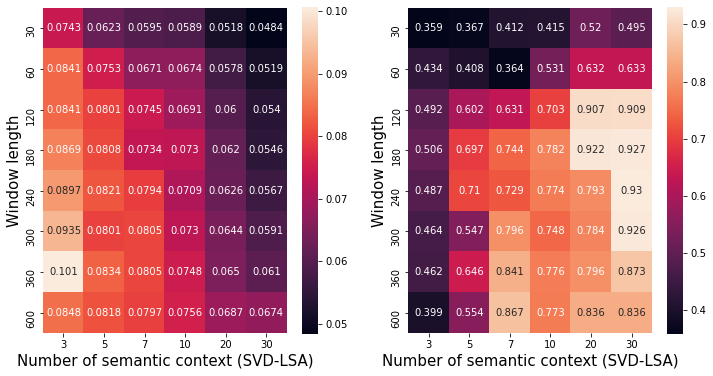

In [37]:
fig,axs = plt.subplots(nrows=1,ncols=2,figsize=(12,6))


sns.heatmap(avg_cor,yticklabels= grid["windows"],xticklabels=grid["n"],annot=True,fmt=".3g", ax =axs[0],square=True)
axs[0].set_ylabel('Window length', fontsize =15)
axs[0].set_xlabel("Number of semantic context (SVD-LSA)",fontsize =15)
# plt.savefig('/Users/enningyang/Downloads/hmm_figs/supfigsxa.png', dpi=600)

sns.heatmap(max_cor,yticklabels= grid["windows"],square=True,xticklabels=grid["n"],annot=True,fmt=".3g", ax=axs[1])
axs[1].set_ylabel('Window length', fontsize =15)
axs[1].set_xlabel("Number of semantic context (SVD-LSA)",fontsize =15)
plt.savefig('/Users/enningyang/Downloads/hmm_figs/sup_grid.png', dpi=600)

Text(0.5, 15.0, 'Number of semantic contexts (SVD-LSA)')

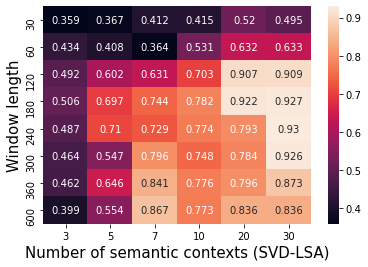

In [22]:
sns.heatmap(max_cor,yticklabels= grid["windows"],xticklabels=grid["n"],annot=True,fmt=".3g")
plt.ylabel('Window length', fontsize =15)
plt.xlabel("Number of semantic contexts (SVD-LSA)",fontsize =15)
plt.savefig('/Users/enningyang/Downloads/hmm_figs/supfigsxb.png', dpi=600)